In [35]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable

sys.path.append(os.path.dirname(os.getcwd()))
from tools.utils import (PERIODIC_TABLE_INFO, PTC_COLNAMES, Encoding,
                         custom_mape, encode_all_structures)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading Data

In [2]:
DATA_DIR = os.path.join(
    os.path.dirname(os.path.dirname(os.getcwd())), "data/"
)

In [3]:
encoding = Encoding.COLUMN_MASS

df = pd.read_csv(os.path.join(DATA_DIR, "data.csv"), index_col=0, na_filter= False)
df = encode_all_structures(df, encoding)

In [4]:
cols_raw = list(df.columns)
cols_trash = ["structure", 'converged', 'accuracy', "n_iterations", "time", "fermi", "total_energy"]
cols_independent = ['delta_E']
cols_drop = cols_trash + cols_independent

cols_dependent = cols_raw.copy()
for element in cols_drop:
    cols_dependent.remove(element)

In [42]:
std_scaler = StandardScaler()
X_raw = torch.Tensor(std_scaler.fit_transform(df[cols_dependent][df["converged"]].values))
y_raw = torch.Tensor(np.abs(df[cols_independent][df["converged"]]).values)

# Train-Test-Split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw,
    test_size=0.2,
    random_state=42
)

In [71]:
# dataloader
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, y_train),
    batch_size=1024, shuffle=True
)

In [115]:
class LogTransform:
    def __init__(self, y):
        self.miny = float(torch.min(y))
        miny2 = sorted(set(list(y.squeeze().numpy())))[1]
        print(self.miny, miny2)
        self.eps = (miny2 - self.miny)/10

    def transform(self, y):
        return np.log(y - self.miny + self.eps)
        
    def inverse_transform(self, logy):
        return np.exp(logy) + self.miny - self.eps

print(y_raw.shape)
log_transform = LogTransform(y_raw)

logy_train = log_transform.transform(y_train)
logy_test = log_transform.transform(y_test)

torch.Size([272762, 1])
0.0 4.999997e-09


In [116]:
# dataloader
train_log_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, logy_train),
    batch_size=1024, shuffle=True
)

# Model definition

In [124]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        N = 50
        self.layers = nn.Sequential(
            nn.Linear(input_size, N),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(N, N),
            nn.ReLU(),
            nn.Linear(N, 1)
        )
        
    def forward(self, x):
        return self.layers(x)

In [125]:
model = MLP(X_train.shape[1])
print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): ReLU()
    (5): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [126]:
# train neural networks on gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): ReLU()
    (5): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [127]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
loss_fn = nn.MSELoss()

epochs = 1500

# train neural networks using batch
model.train()
for epoch in range(epochs):
    train_losses = []
    # for X_batch, y_batch in train_loader:
    for X_batch, y_batch in train_log_loader:
        X_batch, y_batch = X_batch.to(device),y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        train_losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    test_loss = loss_fn(model(X_test.to(device)).cpu().detach(), y_test)
    print(f"[Epoch {epoch+1}/{epochs}]:\ttrain {np.mean(train_losses):.4e}\ttest {test_loss:.4e}", end="\r")

KeyboardInterrupt: 

In [ ]:
model.eval()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=88, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [ ]:
preds = model(X_test).cpu().detach().numpy().squeeze()

Text(0.5, 0, 'ecutwfc')

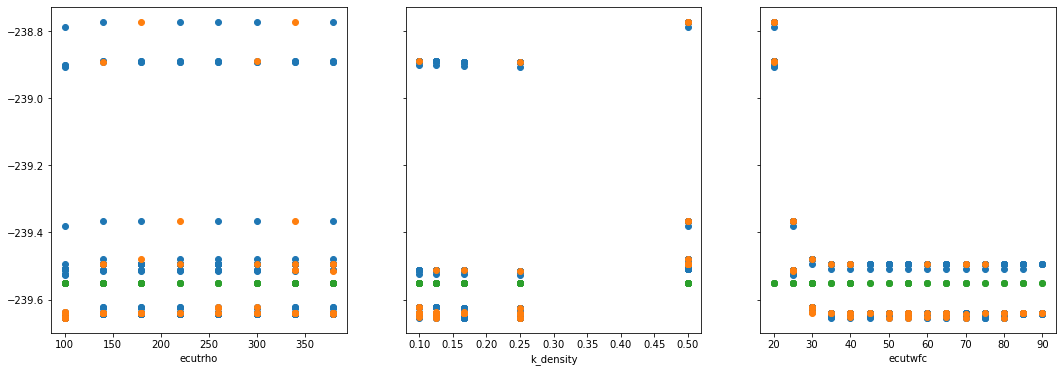

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3,figsize=(18,6), sharey=True)
for i in range(3):
    ax[i].scatter(X_train.numpy()[:,i], y_train)
    ax[i].scatter(X_test.numpy()[:,i], y_test)
    ax[i].scatter(X_test.numpy()[:,i], preds)
ax[0].set_xlabel("ecutrho")
ax[1].set_xlabel('k_density')
ax[2].set_xlabel('ecutwfc')